In [2]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import make_column_transformer
import seaborn as sns

In [3]:
years = list(range(1985, 2023))

In [4]:
url_start = "https://www.basketball-reference.com/awards/awards_{}.html"

In [5]:
for year in years:
    url = url_start.format(year)
    data = requests.get(url)
    with open('mvp/{}.html'.format(year), 'w+', encoding = 'utf-8') as f:
        f.write(data.text)

In [6]:
dfs = []

for year in years:
    with open("mvp/{}.html".format(year), encoding ="utf-8") as f:
        page = f.read()
        
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_ = "over_header").decompose()
    mvp_table = soup.find_all(id='mvp')[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df['Year'] = year
    
    dfs.append(mvp_df)

In [7]:
mvps = pd.concat(dfs)

In [8]:
mvps.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Larry Bird,28,BOS,73.0,763.0,780,0.978,80,39.5,...,10.5,6.6,1.6,1.2,0.522,0.427,0.882,15.7,0.238,1985
1,2,Magic Johnson,25,LAL,1.0,264.0,780,0.338,77,36.1,...,6.2,12.6,1.5,0.3,0.561,0.189,0.843,12.7,0.220,1985
2,3,Moses Malone,29,PHI,0.0,218.0,780,0.279,79,37.4,...,13.1,1.6,0.8,1.6,0.469,0.000,0.815,11.9,0.193,1985
3,4,Kareem Abdul-Jabbar,37,LAL,0.0,206.0,780,0.264,79,33.3,...,7.9,3.2,0.8,2.1,0.599,0.000,0.732,11.2,0.204,1985
4,5,Terry Cummings,23,MIL,2.0,138.0,780,0.177,79,34.5,...,9.1,2.9,1.5,0.8,0.495,0.000,0.741,10.7,0.189,1985


In [9]:
mvps.to_csv('mvps.csv')

Let's try doing this with player stats now.

1. The bball-ref player stats table uses javascript, so we will have to account for that.

In [10]:
player_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"

In [11]:
 for year in years:
    url = player_stats_url.format(year)
    data = requests.get(url)
    with open('player/{}.html'.format(year), 'w+', encoding = 'utf-8') as f:
        f.write(data.text)

In [12]:
df = []
for year in years:
    
    with open('player/{}.html'.format(year), encoding = 'utf-8') as f:
        page = f.read()

        soup = BeautifulSoup(page, 'html.parser')
        soup.find('tr', class_ = "thead").decompose()
        player_table = soup.find_all(id='per_game_stats')[0]
        player_df = pd.read_html(str(player_table))[0]
        player_df['Year'] = year
        
        df.append(player_df)

In [13]:
player_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2022
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,...,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9,2022
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1,2022
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1,2022
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9,2022


In [14]:
player_df = pd.concat(df)

In [15]:
player_df.to_csv('players.csv')

Scrape team records per year

In [16]:
team_stats_url = 'https://www.basketball-reference.com/leagues/NBA_{}_standings.html'

In [17]:
for year in years:
    url = team_stats_url.format(year)
    data = requests.get(url)

    with open ('team/{}.html'.format(year), 'w+',encoding = 'utf-8') as f:
        f.write(data.text)

In [18]:
dfs = []

for year in years:
    with open('team/{}.html'.format(year), encoding = 'utf-8') as f:
        page = f.read()

        soup = BeautifulSoup(page, 'html.parser')
        soup.find('tr', class_='thead').decompose()
        team_table = soup.find_all(id = 'divs_standings_E')
        team = pd.read_html(str(team_table))[0]
        team['Year'] = year
        team['Team'] = team['Eastern Conference']
        del team['Eastern Conference']
        dfs.append(team)

        soup = BeautifulSoup(page, 'html.parser')
        soup.find('tr', class_='thead').decompose()
        team_table = soup.find_all(id = 'divs_standings_W')
        team = pd.read_html(str(team_table))[0]
        team['Year'] = year
        team['Team'] = team['Western Conference']
        del team['Western Conference']
        dfs.append(team)

In [19]:
teams = pd.concat(dfs)
teams['GB'] = teams['GB'].str.replace('—',"0",regex=False)

In [20]:
teams = teams[~teams['W'].str.contains('Division')]

In [21]:
teams['Team'] = teams['Team'].str.replace('*',"", regex=False)

In [22]:
teams.to_csv('teams.csv')

Data Cleaning

In [23]:
mvps = pd.read_csv('mvps.csv')

In [24]:
#Only select the cols that we need, since the players table already contains game stats
mvps = mvps[['Player','Year','Pts Won','Pts Max', 'Share',]]

Clean player data and combine with MVP table


In [25]:
players = pd.read_csv('players.csv')
players

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,0,1,Kareem Abdul-Jabbar*,C,37,LAL,79,79,33.3,9.2,...,2.1,5.8,7.9,3.2,0.8,2.1,2.5,3.0,22.0,1985
1,1,2,Alvan Adams,PF,30,PHO,82,69,26.0,5.8,...,1.9,4.2,6.1,3.8,1.4,0.6,2.4,3.1,14.7,1985
2,2,3,Mark Aguirre,SF,25,DAL,80,79,33.7,9.9,...,2.4,3.6,6.0,3.1,0.8,0.3,3.2,3.1,25.7,1985
3,3,4,Danny Ainge,SG,25,BOS,75,73,34.2,5.6,...,1.0,2.6,3.6,5.3,1.6,0.1,2.0,3.0,12.9,1985
4,4,5,Chuck Aleksinas,C,25,GSW,74,4,15.1,2.2,...,1.2,2.5,3.6,0.5,0.2,0.2,1.0,2.3,5.1,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,836,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,...,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3,2022
21416,837,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,...,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2022
21417,838,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,...,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,2022
21418,839,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,...,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2,2022


In [26]:
# remove unnecessary cols
del players['Unnamed: 0']
del players['Rk']

In [27]:
# remove '*' next to player names for future join
players['Player'] = players['Player'].str.replace('*','', regex=False)

In [28]:
#remove duplicate player rows for players for example who were traded
players.groupby(['Player','Year'])

In [29]:
def single_row(df):
    if df.shape[0] == 1:
        return df
    else:
        row = df[df['Tm'] == 'TOT']
        row['Tm'] = df.iloc[-1,:]['Tm']
        return row
players = players.groupby(['Player','Year']).apply(single_row)

In [30]:
players.index = players.index.droplevel()

In [31]:
players.index = players.index.droplevel()

In [32]:
players[players['Player'] == 'LeBron James']

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
9524,LeBron James,SG,19,CLE,79,79,39.5,7.9,18.9,.417,...,1.3,4.2,5.5,5.9,1.6,0.7,3.5,1.9,20.9,2004
10142,LeBron James,SF,20,CLE,80,80,42.4,9.9,21.1,.472,...,1.4,6.0,7.4,7.2,2.2,0.7,3.3,1.8,27.2,2005
10737,LeBron James,SF,21,CLE,79,79,42.5,11.1,23.1,.480,...,0.9,6.1,7.0,6.6,1.6,0.8,3.3,2.3,31.4,2006
11299,LeBron James,SF,22,CLE,78,78,40.9,9.9,20.8,.476,...,1.1,5.7,6.7,6.0,1.6,0.7,3.2,2.2,27.3,2007
11876,LeBron James,SF,23,CLE,75,74,40.4,10.6,21.9,.484,...,1.8,6.1,7.9,7.2,1.8,1.1,3.4,2.2,30.0,2008
12490,LeBron James,SF,24,CLE,81,81,37.7,9.7,19.9,.489,...,1.3,6.3,7.6,7.2,1.7,1.1,3.0,1.7,28.4,2009
13107,LeBron James,SF,25,CLE,76,76,39.0,10.1,20.1,.503,...,0.9,6.4,7.3,8.6,1.6,1.0,3.4,1.6,29.7,2010
13732,LeBron James,SF,26,MIA,79,79,38.8,9.6,18.8,.510,...,1.0,6.5,7.5,7.0,1.6,0.6,3.6,2.1,26.7,2011
14336,LeBron James,SF,27,MIA,62,62,37.5,10.0,18.9,.531,...,1.5,6.4,7.9,6.2,1.9,0.8,3.4,1.5,27.1,2012
14894,LeBron James,PF,28,MIA,76,76,37.9,10.1,17.8,.565,...,1.3,6.8,8.0,7.3,1.7,0.9,3.0,1.4,26.8,2013


In [33]:
combined = players.merge(mvps, how ='outer', on = ['Player','Year'])

In [34]:
combined.to_csv('combined_plmp.csv')

In [35]:
players

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
492,A.C. Green,PF,22,LAL,82,1,18.8,2.5,4.7,.539,...,2.0,2.7,4.6,0.7,0.6,0.6,1.2,2.8,6.4,1986
891,A.C. Green,PF,23,LAL,79,72,28.4,4.0,7.4,.538,...,2.7,5.1,7.8,1.1,0.9,1.0,1.3,2.2,10.8,1987
1293,A.C. Green,PF,24,LAL,82,64,32.1,3.9,7.8,.503,...,3.0,5.7,8.7,1.1,1.1,0.5,1.5,2.5,11.4,1988
1742,A.C. Green,PF,25,LAL,82,82,30.6,4.9,9.2,.529,...,3.1,5.9,9.0,1.3,1.1,0.7,1.5,2.1,13.3,1989
2204,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,.478,...,3.2,5.5,8.7,1.1,0.8,0.6,1.4,2.5,12.9,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8630,Željko Rebrača,C,29,DET,74,4,15.9,2.6,5.1,.505,...,1.1,2.8,3.9,0.5,0.4,1.0,1.1,2.6,6.9,2002
9130,Željko Rebrača,C,30,DET,30,12,16.3,2.7,4.8,.552,...,0.9,2.2,3.1,0.3,0.2,0.6,1.0,2.6,6.6,2003
9711,Željko Rebrača,C,31,ATL,24,2,11.4,1.4,3.2,.442,...,1.0,1.5,2.4,0.3,0.2,0.5,0.7,2.2,3.8,2004
10311,Željko Rebrača,C,32,LAC,58,2,16.0,2.3,4.0,.568,...,0.8,2.3,3.2,0.4,0.2,0.7,0.8,2.2,5.8,2005


In [36]:
combined[combined['Pts Won'] > 0]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
157,Adrian Dantley,SF,30,UTA,76,75,36.1,10.8,19.1,.563,...,3.5,0.8,0.1,3.0,2.7,29.8,1986,2.0,780.0,0.003
159,Adrian Dantley,SF,32,DET,69,50,31.1,6.4,12.5,.514,...,2.5,0.6,0.1,2.0,2.1,20.0,1988,1.0,800.0,0.001
213,Al Jefferson,C,29,CHA,73,73,35.0,9.6,18.8,.509,...,2.1,0.9,1.1,1.7,2.4,21.8,2014,34.0,1250.0,0.027
309,Alex English,SF,31,DEN,81,81,36.1,11.6,22.4,.518,...,4.2,1.2,0.6,3.1,3.2,27.9,1985,12.0,780.0,0.015
310,Alex English,SF,32,DEN,81,81,37.3,11.7,23.3,.504,...,4.0,0.9,0.4,3.1,2.9,29.8,1986,55.0,780.0,0.071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16128,Vince Carter,SF,24,TOR,75,75,39.7,10.2,22.1,.460,...,3.9,1.5,1.1,2.2,2.7,27.6,2001,7.0,1240.0,0.006
16132,Vince Carter,SF-SG,28,NJN,77,76,36.7,9.0,20.0,.452,...,4.2,1.4,0.6,2.2,3.2,24.5,2005,3.0,1270.0,0.002
16538,World B. Free,SG,31,CLE,71,50,31.7,8.6,18.7,.459,...,4.5,1.1,0.2,2.0,2.3,22.5,1985,2.0,780.0,0.003
16574,Yao Ming,C,23,HOU,82,82,32.8,6.5,12.5,.522,...,1.5,0.3,1.9,2.5,3.3,17.5,2004,1.0,1230.0,0.001


Address NaN values

In [37]:
combined = combined.fillna(0)

In [38]:
combined = combined.apply(pd.to_numeric, errors='ignore')

In [39]:
combined.dtypes

Player      object
Pos         object
Age          int64
Tm          object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
dtype: object

In [40]:
teams = pd.read_csv('teams.csv')

Team names are not consistent across tables, let's address that


In [41]:
teams['Team'].unique()

array(['Boston Celtics', 'Philadelphia 76ers', 'New Jersey Nets',
       'Washington Bullets', 'New York Knicks', 'Milwaukee Bucks',
       'Detroit Pistons', 'Chicago Bulls', 'Cleveland Cavaliers',
       'Atlanta Hawks', 'Indiana Pacers', 'Denver Nuggets',
       'Houston Rockets', 'Dallas Mavericks', 'Utah Jazz',
       'San Antonio Spurs', 'Kansas City Kings', 'Los Angeles Lakers',
       'Portland Trail Blazers', 'Phoenix Suns', 'Seattle SuperSonics',
       'Los Angeles Clippers', 'Golden State Warriors',
       'Sacramento Kings', 'Charlotte Hornets', 'Miami Heat',
       'Orlando Magic', 'Minnesota Timberwolves', 'Toronto Raptors',
       'Vancouver Grizzlies', 'Washington Wizards', 'Memphis Grizzlies',
       'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

In [42]:
combined['Tm'] = combined['Tm'].str.replace('CHA','CHB',regex=False)

In [43]:
combined['Tm'].unique()

array(['LAL', 'PHO', 'DAL', 'MIA', 'CLE', 'WSB', 'CHI', 'GSW', 'IND',
       'WAS', 'MIN', 'BOS', 'HOU', 'DEN', 'ORL', 'NOH', 'TOR', 'SAC',
       'CHO', 'PHI', 'POR', 'DET', 'OKC', 'UTA', 'MIL', 'VAN', 'SEA',
       'NJN', 'NOK', 'LAC', 'ATL', 'CHB', 'MEM', 'NYK', 'NOP', 'BRK',
       'SAS', 'CHH', 'KCK'], dtype=object)

In [44]:
abbr = {}

with open('team_abbr.csv') as f:
    lines = f.readlines()
    for line in lines[1:]:
        abbrev, name = line.replace('\n',"").split(",")
        abbr[abbrev] = name

In [45]:
abbr

{'ATL': 'Atlanta Hawks',
 'BOS': 'Boston Celtics',
 'BRK': 'Brooklyn Nets',
 'CHB': 'Charlotte Bobcats',
 'CHA': 'Charlotte Hornets',
 'CHH': 'Charlotte Hornets',
 'CHO': 'Charlotte Hornets',
 'CHI': 'Chicago Bulls',
 'CLE': 'Cleveland Cavaliers',
 'DAL': 'Dallas Mavericks',
 'DEN': 'Denver Nuggets',
 'DET': 'Detroit Pistons',
 'GSW': 'Golden State Warriors',
 'HOU': 'Houston Rockets',
 'IND': 'Indiana Pacers',
 'KCK': 'Kansas City Kings',
 'LAC': 'Los Angeles Clippers',
 'LAL': 'Los Angeles Lakers',
 'MEM': 'Memphis Grizzlies',
 'MIA': 'Miami Heat',
 'MIL': 'Milwaukee Bucks',
 'MIN': 'Minnesota Timberwolves',
 'NJN': 'New Jersey Nets',
 'NOH': 'New Orleans Hornets',
 'NOK': 'New Orleans/Oklahoma City Hornets',
 'NOP': 'New Orleans Pelicans',
 'NYK': 'New York Knicks',
 'OKC': 'Oklahoma City Thunder',
 'ORL': 'Orlando Magic',
 'PHI': 'Philadelphia 76ers',
 'PHO': 'Phoenix Suns',
 'POR': 'Portland Trail Blazers',
 'SAC': 'Sacramento Kings',
 'SAS': 'San Antonio Spurs',
 'SEA': 'Seattle 

In [46]:
combined['Team'] = combined['Tm'].map(abbr)

In [47]:
stats = combined.merge(teams, how = 'left', on = ['Team','Year'])

In [48]:
stats

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Share,Team,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,22,LAL,82,1,18.8,2.5,4.7,0.539,...,0.0,Los Angeles Lakers,8,62,20,0.756,0.0,117.3,109.5,6.84
1,A.C. Green,PF,23,LAL,79,72,28.4,4.0,7.4,0.538,...,0.0,Los Angeles Lakers,8,65,17,0.793,0.0,117.8,108.5,8.32
2,A.C. Green,PF,24,LAL,82,64,32.1,3.9,7.8,0.503,...,0.0,Los Angeles Lakers,8,62,20,0.756,0.0,112.8,107.0,4.81
3,A.C. Green,PF,25,LAL,82,82,30.6,4.9,9.2,0.529,...,0.0,Los Angeles Lakers,8,57,25,0.695,0.0,114.7,107.5,6.38
4,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,0.478,...,0.0,Los Angeles Lakers,9,63,19,0.768,0.0,110.7,103.9,6.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16720,Željko Rebrača,C,29,DET,74,4,15.9,2.6,5.1,0.505,...,0.0,Detroit Pistons,8,50,32,0.610,0.0,94.3,92.2,1.69
16721,Željko Rebrača,C,30,DET,30,12,16.3,2.7,4.8,0.552,...,0.0,Detroit Pistons,8,50,32,0.610,0.0,91.4,87.7,2.97
16722,Željko Rebrača,C,31,ATL,24,2,11.4,1.4,3.2,0.442,...,0.0,Atlanta Hawks,14,28,54,0.341,33.0,92.8,97.5,-5.00
16723,Željko Rebrača,C,32,LAC,58,2,16.0,2.3,4.0,0.568,...,0.0,Los Angeles Clippers,9,37,45,0.451,25.0,95.7,96.5,-0.47


In [49]:
del stats['Unnamed: 0']

In [50]:
stats.dtypes

Player      object
Pos         object
Age          int64
Tm          object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W            int64
L            int64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [51]:
stats = stats.apply(pd.to_numeric, errors='ignore')

In [52]:
stats.dtypes

Player      object
Pos         object
Age          int64
Tm          object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W            int64
L            int64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [53]:
stats.to_csv('player_mvp_stats.csv')

In [54]:
scoring_leaders = stats[stats['G'] > 70].sort_values('PTS', ascending = False).head(10)

<AxesSubplot:xlabel='Player'>

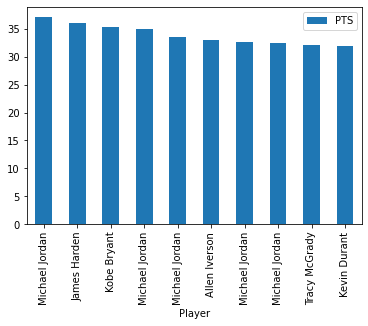

In [55]:
scoring_leaders.plot.bar('Player', 'PTS')

In [56]:
high_scores = stats.groupby('Year').apply(lambda x: x.sort_values('PTS',ascending=False).head(1))

<AxesSubplot:xlabel='Year'>

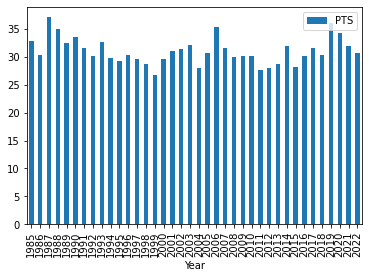

In [57]:
high_scores.plot.bar('Year','PTS')

Check correlation

In [58]:
stats.corr()['Share']

Age        0.018226
G          0.090328
GS         0.170386
MP         0.166153
FG         0.277797
FGA        0.250977
FG%        0.067774
3P         0.088092
3PA        0.088420
3P%        0.032185
2P         0.276265
2PA        0.252024
2P%        0.063559
eFG%       0.060970
FT         0.323371
FTA        0.324130
FT%        0.044791
ORB        0.109419
DRB        0.217832
TRB        0.192063
AST        0.207314
STL        0.185046
BLK        0.149553
TOV        0.236249
PF         0.074246
PTS        0.291598
Year      -0.013605
Pts Won    0.989627
Pts Max    0.518536
Share      1.000000
W          0.123508
L         -0.122268
W/L%       0.126547
GB        -0.102595
PS/G       0.044661
PA/G      -0.034742
SRS        0.121298
Name: Share, dtype: float64

<AxesSubplot:>

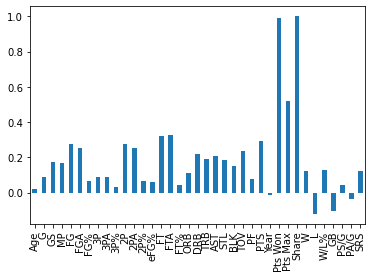

In [59]:
stats.corr()['Share'].plot.bar()

Check for nulls

In [60]:
pd.isnull(stats).sum()

Player     0
Pos        0
Age        0
Tm         0
G          0
GS         0
MP         0
FG         0
FGA        0
FG%        0
3P         0
3PA        0
3P%        0
2P         0
2PA        0
2P%        0
eFG%       0
FT         0
FTA        0
FT%        0
ORB        0
DRB        0
TRB        0
AST        0
STL        0
BLK        0
TOV        0
PF         0
PTS        0
Year       0
Pts Won    0
Pts Max    0
Share      0
Team       0
W          0
L          0
W/L%       0
GB         0
PS/G       0
PA/G       0
SRS        0
dtype: int64

Remove Player, Pts Won, Pts Max, Share because these values are what we are trying to predict, and leaving them in could lead to correlation issues. We will also remove 'Team' and 'Tm', as these columns were only used to join the win/loss data.

In [61]:
stats.columns
stats = stats.drop(['Team','Tm'], axis=1)

Before we actually start any modelling work, we have to account for our categorical variable, 'Pos' (player position). We can use One-Hot Encoding in order to create dummy variables and represent each position as a binary vector. For the purposes of simplifying our model, I will replace any multi-positional indicators such as 'PF-C' (Power Forward - Center) to just the first position indicated.

In [62]:
stats['Pos'].unique()

array(['PF', 'SF', 'C', 'SG', 'PG', 'SG-SF', 'PF-C', 'SF-PF', 'SF-SG',
       'PF-SF', 'SG-PG', 'PG-SG', 'C-PF', 'SF-C', 'PG-SF', 'SG-PF',
       'SG-PG-SF'], dtype=object)

In [63]:
stats['Pos'] = stats['Pos'].replace(r'-\w+', '', regex=True)

In [64]:
transformer = make_column_transformer((OneHotEncoder(), ['Pos']), remainder = 'passthrough')

In [65]:
transformed = transformer.fit_transform(stats)
enc_stats = pd.DataFrame(transformed, columns = transformer.get_feature_names_out())

In [66]:
enc_stats.columns = enc_stats.columns.str.replace(r'^\w+__','',regex=True)

In [67]:
enc_stats = enc_stats.apply(pd.to_numeric, errors='ignore')

In [68]:
enc_stats.dtypes

Pos_C      float64
Pos_PF     float64
Pos_PG     float64
Pos_SF     float64
Pos_SG     float64
Player      object
Age          int64
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
W            int64
L            int64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [69]:
enc_stats.columns

Index(['Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG', 'Player', 'Age', 'G',
       'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Year', 'Pts Won', 'Pts Max', 'Share', 'W', 'L',
       'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'],
      dtype='object')

In [70]:
enc_stats.to_csv('enc_stats.csv')

Select/define features for cross validation and modelling

In [71]:
predictors = ['Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG', 'Age', 'G',
       'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Year', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS']

Separate train/test data

In [72]:
train = enc_stats[~(enc_stats['Year'] == 2022)]
test = enc_stats[enc_stats['Year'] == 2022]

<AxesSubplot:>

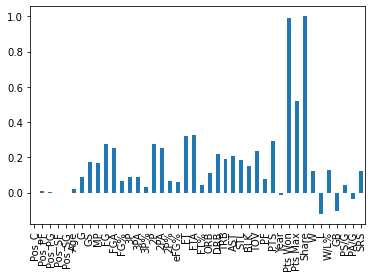

In [73]:
enc_stats.corr()['Share'].plot.bar()

In [74]:
X_mvp = train[predictors]

In [75]:
y_mvp = train[['Share']]

Let's use a random forest model since we have a categorical independent variable. (A player can either win MVP or not) 400 random trees, and our model will make a split when there is a minimum of 5 samples at an internal node.

In [76]:
#create scoring functions
regression_score = {'R^2 score' : 'r2',
    'Explained Variance' : 'explained_variance',
    'MSE' : 'neg_mean_squared_error',
    'RMSE' : make_scorer(mean_squared_error, squared=False)}



def cross_validation_score(model, X, y, scoring, CV):
    '''
    Cross-validation metrics
    
    param_model: model
    param_X: features
    param_y: target label
    param_scoring: a selection of metrics
    param_CV: number of cross-validation folds
    '''
    scores = cross_validate(model, X, y.values.ravel(), scoring=scoring, cv=CV)

    return {metric: (round(np.mean(scores),3),
    [round(np.std(scores),3)]) for metric, scores in scores.items()}

In [77]:
rf = RandomForestRegressor(n_estimators=500, random_state = 1, min_samples_split = 5, criterion = 'squared_error')

In [78]:
#10-fold cross validation
rf_scores = cross_validation_score(rf, X_mvp, y_mvp, regression_score, 10)
rf_scores

{'fit_time': (74.168, [2.554]),
 'score_time': (0.068, [0.003]),
 'test_R^2 score': (0.501, [0.21]),
 'test_Explained Variance': (0.502, [0.21]),
 'test_MSE': (-0.001, [0.001]),
 'test_RMSE': (0.036, [0.009])}

Now we can start making predictions

In [79]:
rf.fit(X_mvp, y_mvp.values.ravel())

#create list of predictions
rf_pred = rf.predict(test[predictors]).round(decimals=4)
#pair player names w predictions, sort descending
rflist_unsort = [[i, j] for i, j in zip(test['Player'], rf_pred)]
rf_list = sorted(rflist_unsort, key = lambda x:x[1], reverse=True)
#create datafrom from list of predictions
rf_df = pd.DataFrame(rf_list)
rf_df.rename(columns = {0:'Player',1:'Share'}, inplace=True)

#re-index for readability
rf_df.index = rf_df.index + 1
rf_df

,Player,Share
1,Devin Booker,0.5139
2,Joel Embiid,0.4182
3,Ja Morant,0.3585
4,Giannis Antetokounmpo,0.3571
5,Nikola Jokić,0.3478
...,...,...
601,Yves Pons,0.0000
602,Zach Collins,0.0000
603,Zeke Nnaji,0.0000
604,Ziaire Williams,0.0000


In [80]:
rf_df_top10 = rf_df.head(12)
rf_df_top10

,Player,Share
1,Devin Booker,0.5139
2,Joel Embiid,0.4182
3,Ja Morant,0.3585
4,Giannis Antetokounmpo,0.3571
5,Nikola Jokić,0.3478
6,LeBron James,0.2399
7,Luka Dončić,0.2372
8,Kevin Durant,0.2198
9,Jayson Tatum,0.1497
10,James Harden,0.1278


<AxesSubplot:>

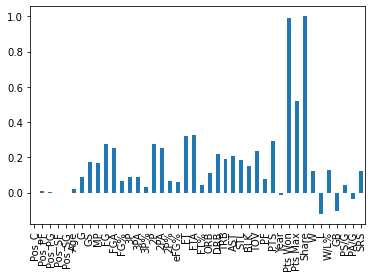

In [84]:
enc_stats.corr()['Share'].plot.bar()